This notebook evaluates a hardware multiplier for the **MXInt4** format that was generated automatically using program synthesis.

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import subprocess
import os
import sys

from a_cx_mxint_quant.quantizers import mxint_hardware

EXP_WIDTH = 4
MANT_WIDTH = 4
Q_CONFIG = {"width": MANT_WIDTH, "exponent_width": EXP_WIDTH, "round_bits": 0}
PARALLELISM = [1, 1]

SOLUTION_MANT_FILE = "solution_mant.txt"
SOLUTION_EXP_FILE = "solution_exp.txt"
OUTPUT_FILE_PATH = "evaluate.sl"

In [32]:


def gen_eval(solution_filepath, input_call_string, output_filepath):
    """
    Generates the file to run the SYGUS code
    """
    try:
        with open(solution_filepath, 'r') as f:
            solution_content = f.read()
    except FileNotFoundError:
        print(f"Error: Solution file not found at '{solution_filepath}'")
        sys.exit(1)

    match = re.search(r'\(define-fun', solution_content)
    if not match:
        print(f"Error: Could not find a '(define-fun ...)' expression in '{solution_filepath}'")
        sys.exit(1)

    function_definition = solution_content.strip()
    if function_definition.startswith('(') and function_definition.endswith(')'):
        function_definition = function_definition[1:-1].strip()

    return_type_pattern = re.compile(
        r'\(define-fun\s+.*?\s+\(.*\)\s+(?P<return_type>\(_\s+BitVec\s+\d+\)).*',
        re.DOTALL
    )

    type_match = return_type_pattern.match(function_definition)
    if not type_match:
        print("Error: Could not parse the return type from the function definition.")
        print("Function definition looked like this:\n", function_definition)
        sys.exit(1)

    return_type = type_match.group('return_type')

    output_content = f"""(set-logic BV)

{function_definition}

(synth-fun output () {return_type})

(constraint (= output {input_call_string}))

(check-synth)
"""

    try:
        with open(output_filepath, 'w') as f:
            f.write(output_content)
    except IOError as e:
        print(f"Error writing to file '{output_filepath}': {e}")
        sys.exit(1)




In [33]:

def synth_output(smt_filepath):
    """
    Runs the SYGUS code in evaluate.sl
    """

    command = ["cvc5", smt_filepath]

    try:

        result = subprocess.run(
            command,
            capture_output=True,
            text=True,
            check=True
        )



        output_str = result.stdout.strip()

        parts = output_str.replace('(', ' ').replace(')', ' ').split()

        if not parts:
            print("Error: CVC5 produced empty output.")
            return None

        value = parts[-1]


        if value.startswith("#b") or value.startswith("#x") or value.isnumeric():
             return value
        else:
            print(f"Error: Could not parse a valid value from CVC5 output. Last token was '{value}'")
            print(f"Full output was:\n{output_str}")
            return None


    except FileNotFoundError:
        print(f"Error: The '{command[0]}' command was not found.")
        print("Please make sure CVC5 is installed and in your system's PATH.")
        return None
    except subprocess.CalledProcessError as e:

        print(f"Error: CVC5 failed with exit code {e.returncode}.")
        print("--- CVC5 Standard Error ---")
        print(e.stderr)
        print("---------------------------")
        return None




In [34]:


def extract_function_call(constraint_string):

    pattern = re.compile(r'\(= \s*(\(.*?\))')

    match = pattern.search(constraint_string)

    if match:
        return match.group(1)
    else:
        return None



In [35]:

def bit_to_int(bv_string: str) -> int:
    binary_part = bv_string[2:]
    unsigned_value = int(binary_part, 2)
    return unsigned_value if binary_part[0] == '0' else unsigned_value - (1 << len(binary_part))




In [36]:
# In[16]:


from a_cx_mxint_quant.quantizers import mxint_hardware
from loop import to_twos_complement, mxint_mult, gen_mxint_constraint

import torch
import random
import numpy as n

EXPONENT_WIDTH = 4
Q_CONFIG_IN1 = {"width": 4, "exponent_width": EXPONENT_WIDTH, "round_bits": 0}
Q_CONFIG_IN2 = {"width": 4, "exponent_width": EXPONENT_WIDTH, "round_bits": 0}
Q_CONFIG_OUT = {"width": 4, "exponent_width": EXPONENT_WIDTH, "round_bits": 0}
PARALLELISM = [1, 1]

FLOAT_MIN = -8
FLOAT_MAX = 8





In [ ]:

gt = []
synth = []
num_iters = 100

"""
floats = [
        (7.5, 0.25),
        (0.25, 7.5),
        (-6.0, 0.5),
        (7.0, 6.0),
        (-0.5, -0.75),
        (3.0, 3.0),
        (4.0, -0.5),
    ]
"""



for i  in range(num_iters):

    rand1 = random.randint(-10, 10)
    rand2 = random.randint(-10, 10)

    f1 = 0.25 * rand1
    f2 = 0.25 * rand2

    #f1 = random.uniform(-8,8)
    #f2 = random.uniform(-8, 8)
    

    #f1 = np.random.normal(loc=0.0, scale=1.0)
    #f2 = np.random.normal(loc=0.0, scale=1.0)
   

    #f1 =floats[i][0]
    #f2 = floats[i][1]


    tensor1 = torch.tensor([[f1]])
    tensor2 = torch.tensor([[f2]])

    _, mant_tensor1, exp_tensor1 = mxint_hardware(tensor1, Q_CONFIG_IN1, PARALLELISM)
    _, mant_tensor2, exp_tensor2 = mxint_hardware(tensor2, Q_CONFIG_IN2, PARALLELISM)

    in1_mant_val = int(mant_tensor1.item())
    in1_exp_val = int(exp_tensor1.item())
    in2_mant_val = int(mant_tensor2.item())
    in2_exp_val = int(exp_tensor2.item())


    _,_,_,_, out_mant_val, out_exp_val = mxint_mult(f1, f2, Q_CONFIG_IN1, Q_CONFIG_IN2, Q_CONFIG_OUT, PARALLELISM)

    gt_result = (out_mant_val,out_exp_val)
    gt.append(gt_result)


    #mantisssa
    constraint = gen_mxint_constraint(f1, f2,"mant", 0)
    #print(constraint)
    get_function_call = extract_function_call(constraint)
    #print(get_function_call)
    gen_eval("solution_mant.txt", get_function_call, OUTPUT_FILE_PATH)
    synth_str_mant = synth_output(OUTPUT_FILE_PATH)
    #print(synth_str)
    #print(bit_to_int(synth_str))
    
    #exp
    constraint = gen_mxint_constraint(f1, f2,"exp", 0)
    get_function_call = extract_function_call(constraint)
    gen_eval("solution_exp.txt", get_function_call, OUTPUT_FILE_PATH)
    synth_str_exp = synth_output(OUTPUT_FILE_PATH)
    

    synth_result = (bit_to_int(synth_str_mant), bit_to_int(synth_str_exp))
    #synth_result = (bit_to_int(synth_str_mant), out_exp_val)
    synth.append(synth_result)

    if i%100 == 0 and i >0 :
        print("iteration:", i)




Total Test Cases:         100
Max Mantissa Error:       12
Mean Mantissa Error:      1.8900
Median Mantissa Error:    0.0000
Exact Matches: 58.00


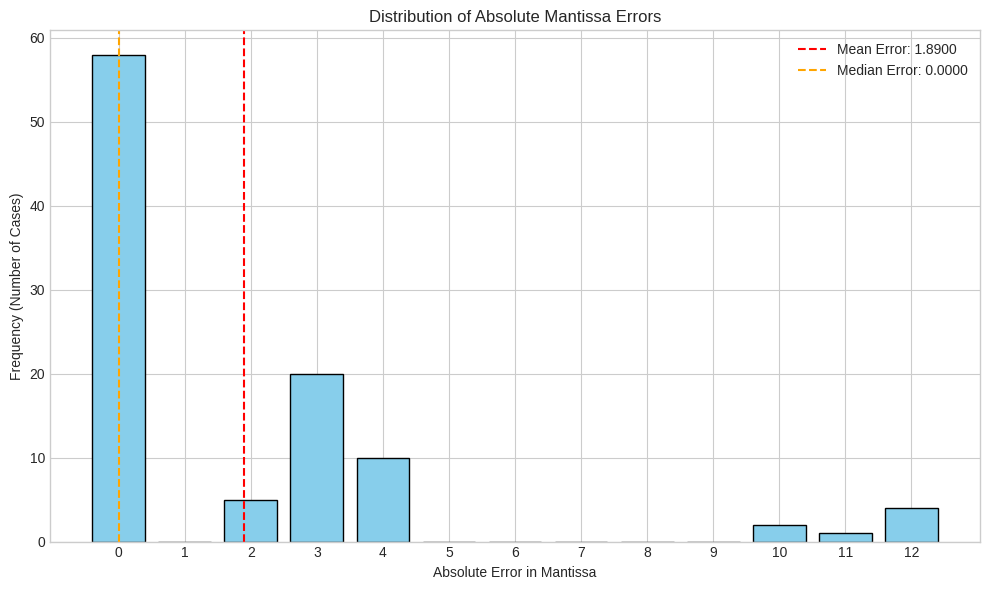

In [38]:


gt_mantissas = np.array([m for m, e in gt])
synth_mantissas = np.array([m for m, e in synth])



mantissa_errors = np.abs(gt_mantissas - synth_mantissas)


mean_error = np.mean(mantissa_errors)
median_error = np.median(mantissa_errors)
max_error = np.max(mantissa_errors)


num_exact_matches = np.sum(mantissa_errors == 0)
total_cases = len(mantissa_errors)
percent_exact = (num_exact_matches / total_cases) * 100



print(f"Total Test Cases:         {total_cases}")
print(f"Max Mantissa Error:       {max_error}")
print(f"Mean Mantissa Error:      {mean_error:.4f}")
print(f"Median Mantissa Error:    {median_error:.4f}")
print(f"Exact Matches: {percent_exact:.2f}")


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))


bins = np.arange(max_error + 2) - 0.5
ax.hist(mantissa_errors, bins=bins, color='skyblue', edgecolor='black', rwidth=0.8)


ax.axvline(mean_error, color='red', linestyle='--', label=f'Mean Error: {mean_error:.4f}')
ax.axvline(median_error, color='orange', linestyle='--', label=f'Median Error: {median_error:.4f}')


ax.set_title("Distribution of Absolute Mantissa Errors")
ax.set_xlabel("Absolute Error in Mantissa")
ax.set_ylabel("Frequency (Number of Cases)")
ax.set_xticks(np.arange(max_error + 1)) 
ax.legend()

plt.tight_layout()
plt.show()

Total Test Cases:         100
Max Exponent Error:       7
Mean Exponent Error:      0.3400
Median Exponent Error:    0.0000
Exact Matches: 73.00%


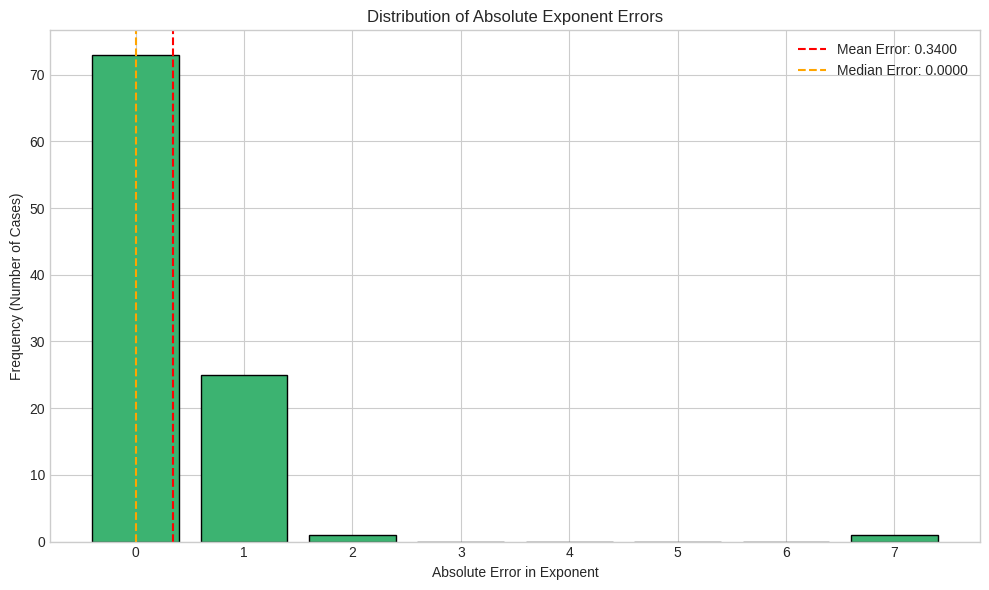

In [39]:
gt_exponents = np.array([e for m, e in gt])
synth_exponents = np.array([e for m, e in synth])

exponent_errors = np.abs(gt_exponents - synth_exponents)


mean_error = np.mean(exponent_errors)
median_error = np.median(exponent_errors)
max_error = np.max(exponent_errors)

num_exact_matches = np.sum(exponent_errors == 0)
total_cases = len(exponent_errors)
percent_exact = (num_exact_matches / total_cases) * 100


print(f"Total Test Cases:         {total_cases}")
print(f"Max Exponent Error:       {max_error}")
print(f"Mean Exponent Error:      {mean_error:.4f}")
print(f"Median Exponent Error:    {median_error:.4f}")
print(f"Exact Matches: {percent_exact:.2f}%")


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

bins = np.arange(max_error + 2) - 0.5
ax.hist(exponent_errors, bins=bins, color='mediumseagreen', edgecolor='black', rwidth=0.8)


ax.axvline(mean_error, color='red', linestyle='--', label=f'Mean Error: {mean_error:.4f}')
ax.axvline(median_error, color='orange', linestyle='--', label=f'Median Error: {median_error:.4f}')


ax.set_title("Distribution of Absolute Exponent Errors")
ax.set_xlabel("Absolute Error in Exponent")
ax.set_ylabel("Frequency (Number of Cases)")
ax.set_xticks(np.arange(max_error + 1))
ax.legend()

plt.tight_layout()
plt.show()


In [40]:
# In[18]:


def dequantize_pair(mantissa: int, exponent: int, width: int) -> float:
    scaling_factor = 2.0 ** (width - 1)
    return (mantissa * (2.0 ** exponent)) / scaling_factor




In [41]:
# In[19]:



gt_dequantized = np.array([dequantize_pair(m, e, Q_CONFIG_OUT["width"]) for m, e in gt])
synth_dequantized = np.array([dequantize_pair(m, e, Q_CONFIG_OUT["width"]) for m, e in synth])



print("GT Dequantized:", gt_dequantized[:10])
print("Synth Dequantized:", synth_dequantized[:10])




GT Dequantized: [  1.25   -10.       3.       7.       1.5      0.       4.       2.5
   3.5      0.1875]
Synth Dequantized: [ 0.5     -5.       1.5      3.       1.5      0.       4.       2.5
  3.5      0.09375]


Percentage within 0.1: 44.00%
Mean absolute error: 2.3497
Median absolute error: 0.5000


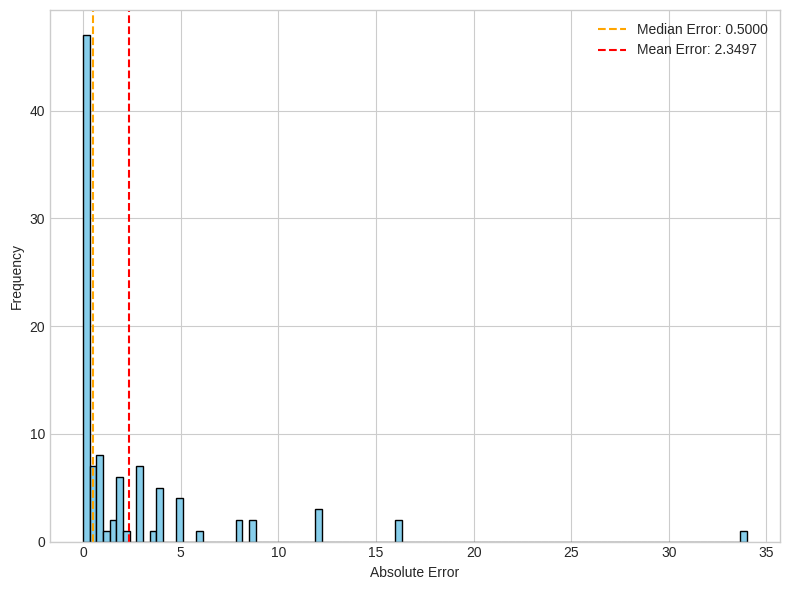

In [42]:
# In[20]:


abs_error = np.abs(gt_dequantized - synth_dequantized)

tolerance = 0.1
percentage_within = np.sum(abs_error < tolerance) / len(abs_error) * 100
mean_error = np.mean(abs_error)
median_error = np.median(abs_error)


print(f"Percentage within {tolerance}: {percentage_within:.2f}%")
print(f"Mean absolute error: {mean_error:.4f}")
print(f"Median absolute error: {median_error:.4f}")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(abs_error, bins=100, color='skyblue', edgecolor='black')
ax.set_xlabel("Absolute Error")
ax.set_ylabel("Frequency")


ax.axvline(np.median(abs_error), color='orange', linestyle='--', label=f'Median Error: {np.median(abs_error):.4f}')
ax.axvline(np.mean(abs_error), color='r', linestyle='--', label=f'Mean Error: {np.mean(abs_error):.4f}')
ax.legend()


plt.tight_layout()
plt.show()
